In [9]:
!pip install transformers
!pip install rouge-score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
import torch
import os
import re
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from tqdm.notebook import tqdm
#Train on GPU if available (go to 'Edit/Notebook Settings' in Colab to enable)
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [0]:

def clean_v3(text):
  #Remove code blocks, urls, and html tags.
  text = re.sub(r'<code[^>]*>(.+?)</code\s*>', '', text,flags=re.DOTALL | re.MULTILINE)
  text = re.sub(r'<div[^>]*>(.+?)</div\s*>', '', text,flags=re.DOTALL | re.MULTILINE)
  text = re.sub(r'<blockquote[^>]*>(.+?)</blockquote\s*>', '', text,flags=re.DOTALL | re.MULTILINE)
  text = re.sub('<.*?>', '', text)
  text = text.replace('&quot;','"')
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'www.\S+', '', text)
  return text


def train_data(directory):
    df = pd.read_csv(filename)
    mask = (df['ClosedDate'].isna())*(~df['AcceptedAnswerId'].isna())
    X,y= df[mask]['Body'].values,df[mask]['Title'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_per_step, random_state=42)
    train_gen = enumerate(zip(X_train,y_train))
    for step in range(num_steps):
      for i,(X_i,y_i) in tqdm(enumerate(zip(X_test,y_test)),total=test_per_step):
        yield 'test',i,clean_v3(X_i),y_i
      for i,(X_i,y_i) in tqdm(train_gen,total=train_per_step):
        i -= step*train_per_step
        if i>=train_per_step:
          break
        yield 'train',i,clean_v3(X_i),y_i
      yield 'checkpoint',step,clean_v3(X_i),y_i

In [0]:
#Fine-tuning T5 to summarize a question into a title.
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=0.001/128)
#Evaluation mode disables dropout layers, which aren't needed when we only train for a single epoch.
model.eval()

filename = '/content/drive/My Drive/Colab Notebooks/BERT_6-10/so_4.csv'
num_steps = 14
train_per_step = 10000
test_per_step = 100

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
rouge1 = 0
rouge2 = 0
train_loss = 0
summaries = []
#Training loop
for mode,i,X_i,y_i in train_data(filename):
  if mode=='train':
    #Encode the titles (the prefix 'summarize: ' tells it to summarize)
    X_i = tokenizer.encode('summarize: '+X_i, return_tensors="pt",max_length=512,pad_to_max_length=True).to(device)
    y_i = tokenizer.encode(y_i, return_tensors="pt",max_length=512,pad_to_max_length=True).to(device)
    #Foward pass through the network
    loss = model(input_ids=X_i, lm_labels=y_i)[0]
    train_loss += loss.detach().cpu().numpy()
    #Backward pass to compute the gradients
    loss.backward()
    #Update the parameters with gradient descent
    optimizer.step()
    optimizer.zero_grad()
    model.zero_grad()
  elif mode=='test':
    #Compute the loss, ROUGE score, and some example titles.
    #Print some example titles, to gauge how well it's doing (needs many more training examples to produce reasonable results)
    with torch.no_grad():
      X_i = tokenizer.encode(X_i, return_tensors="pt",max_length=512).to(device)
      summary = model.generate(X_i,max_length=200,num_beams=1,no_repeat_ngram_size=3)[0]
      summary = tokenizer.decode(summary, skip_special_tokens=True)
      summaries.append(summary + '\n')
      scores = scorer.score(y_i,summary)
      rouge1 += scores['rouge1'].fmeasure
      rouge2 += scores['rouge2'].fmeasure
  elif mode=='checkpoint':
    #Save the model
    print()
    print('Saving model...')
    print()
    checkpoint_directory = f'/content/drive/My Drive/Colab Notebooks/T5_6-10/{i}'
    if not os.path.exists(checkpoint_directory):
        os.makedirs(checkpoint_directory)
    model.save_pretrained(checkpoint_directory)
    #Save the validation scores.
    with open(checkpoint_directory+'/validation.txt','w') as f:
      f.write(f'Train Loss: {train_loss/train_per_step}\n')
      f.write(f'Rouge 1: {rouge1/test_per_step}\n')
      f.write(f'Rouge 2: {rouge2/test_per_step}\n')
      f.writelines(summaries)
    rouge1 = 0
    rouge2 = 0
    train_loss = 0
    summaries = []

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "



Saving model...




Saving model...




Saving model...




Saving model...




Saving model...




Saving model...




Saving model...



In [0]:
tr = np.reshape(np.array(test_results),[14,-1,3])

In [0]:
df = pd.read_csv(filename)
df['Answer1'] = df['AnswerCount']>=1
df['Answer2'] = df['AnswerCount']>=2
df['AnswerAcc'] = ~df['AcceptedAnswerId'].isna()
mask = (df['ClosedDate'].isna())
X,y= df[mask]['Title'].values,df[mask][['Answer1','Answer2','AnswerAcc']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_per_step, random_state=42)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
def get_roc_auc(true_out,raw_out):
  prob = np.exp(raw_out)/(1+np.exp(raw_out))
  return roc_auc_score(true_out,prob)
    
def get_rsq(true_out,raw_out):
  return r2_score(true_out,raw_out)

def multi_score(y_actual,hidden_out):
  out = []
  score_functions = 3*[get_roc_auc]+[get_rsq]
  for raw_out,true_out,scorer in zip(np.transpose(hidden_out),np.transpose(y_actual),score_functions):
    out.append(scorer(true_out,raw_out))
  return out

#multi_score(y_test.astype(int),tr[-1])
scores = [multi_score(y_test.astype(int),tr_step) for tr_step in tr]


In [10]:
device

device(type='cuda')

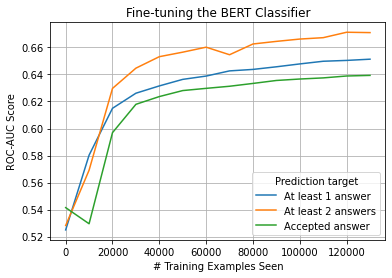

In [0]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,130000,14),scores)
plt.xlabel('# Training Examples Seen')
plt.ylabel('ROC-AUC Score')
plt.legend(['At least 1 answer','At least 2 answers','Accepted answer'],title='Prediction target')
#plt.gca().tick_params(right=True,labelright=True,left=False,labelleft=False)
#plt.gca().yaxis.set_label_position("right")
#plt.gca().yaxis.tick_right()
plt.grid()
plt.title('Fine-tuning the BERT Classifier')
plt.savefig('bert_roc_auc.png',dpi=500)

In [0]:
np.save('tr.npy',tr)

In [0]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
checkpoint_directory = '/content/drive/My Drive/Colab Notebooks/BERT_6-10/BERT_6-10'
model.save_pretrained(checkpoint_directory)